# SVM Model

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## 1. Reading Dataset & Exploring

In [84]:
# Read dataset
species = pd.read_csv('extinction-threat-to-indigenous-land-species.csv')

# Basic Info
species.info()
print()
print(species.isnull().sum())

# Slecting num of rows
species_small = species.iloc[:10000]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11861 entries, 0 to 11860
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   report_name                 11861 non-null  object 
 1   common_name                 8734 non-null   object 
 2   m_ori_name                  700 non-null    object 
 3   species_name                11861 non-null  object 
 4   category                    11861 non-null  object 
 5   subcategory                 11861 non-null  object 
 6   status_change               9469 non-null   object 
 7   subcategory_change          9420 non-null   object 
 8   assessment_id               11861 non-null  int64  
 9   report_id                   11861 non-null  int64  
 10  species_id                  11861 non-null  int64  
 11  genus                       11861 non-null  object 
 12  family                      11861 non-null  object 
 13  order                       118

## 2. Preprocessing - Handling Missing Data

In [87]:
# Feature Selection: Selecting important columns
selected_cols = [
    'order', 'class', 'kingdom', 'domain', 'genus', 'conservation_dependent', 'population_trend', 
    'phylum', 'family', 'pop_size', 'trend_confidence', 'time_span_years', 'qualifiers', 'bio_status']

X = species_small[selected_cols]
y = species_small['category'] # target variable

# Handle missing values
X = X.fillna('Unknown')

### Encoding 

In [90]:
# Encode categorical columns
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Lable Encode
y_encoded = LabelEncoder().fit_transform(y)

# New Modified Data

## 3. Splitting Data

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

## 4. Scaling Features

In [96]:
# Standard Scaling for SVM - best option
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Tuning SVM Parameters Using Gird Search for Improved Accuracy

In [99]:
# Bigger grid = better model search
param_grid = {
    'C': [1, 10, 20],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # for poly kernels
}
grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid.best_params_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 20, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


## 6. Model Prediction:
- Accuracy: Overall correctness
- Precision: Of all things I predicted for a class, how many were actually correct? (Higher = better)
- Recall: Of all things that really belonged to a class, how many did we find? (Higher = better)
- F1 Score: Precision & Recall
- Confusion Matrix:

Train Accuracy: 0.8771
Final Accuracy: 0.8217

Classification Report:
                                precision    recall  f1-score   support

At risk of becoming threatened       0.80      0.80      0.80       769
                Data deficient       0.80      0.84      0.82       886
                Not threatened       0.87      0.87      0.87      1119
                    Threatened       0.71      0.54      0.61       226

                      accuracy                           0.82      3000
                     macro avg       0.80      0.76      0.78      3000
                  weighted avg       0.82      0.82      0.82      3000



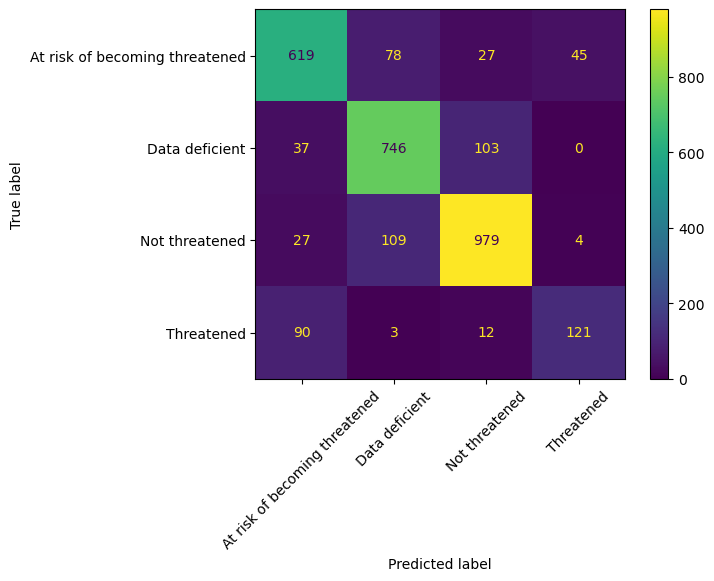

In [101]:
y_pred = grid.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Accuracy for training set (70% of dataset) and testing set (30% of dataset)
train_acc = grid.best_estimator_.score(X_train_scaled, y_train)
print(f"Train Accuracy: {train_acc:.4f}") 

final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {final_accuracy:.4f}")

# Full Classification Report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LabelEncoder().fit(species_small['category']).classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(species_small['category']).classes_)
disp.plot(xticks_rotation=45)